# Time delays

The time-delay surface is 

$$ t(\vec\theta) \propto \left[\frac{1}{2}(\vec\theta-\vec\beta)^2-\hat\Psi(\vec\theta)\right] $$

The two terms entering this equations are called the geometrical and the gravitational time delays, respectively. 

In the follwoing example, we reduce the problem to one dimension. Instead of dealing with a time-delay surface, we consider a time-delay function (by simply substituting the vectors $\vec\theta$ and $\vec\beta$ with two scalars. We will change the relative position of source and lens to see how the time-delay function changes.

We consider a lensing potential in the form:
$$
\hat\Psi(\theta) \propto \frac{1}{\sqrt{\theta^2+\theta_c^2}}
$$

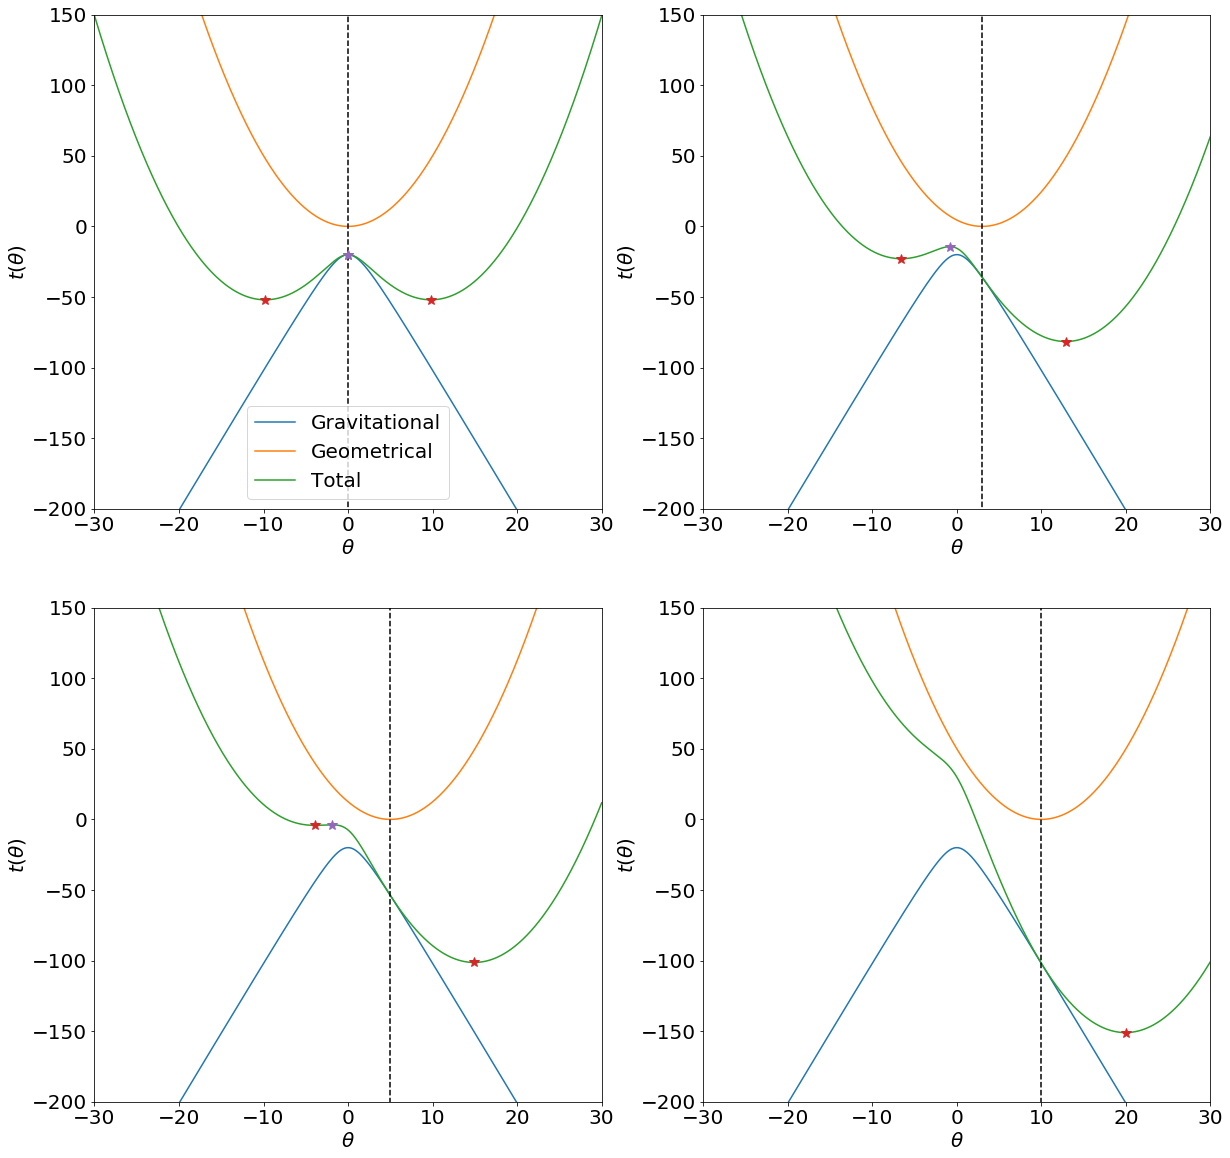

In [1]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 25}
import matplotlib
matplotlib.rc('font', **font)

label_size = 20
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size

import numpy as np
import matplotlib.pyplot as plt

theta=np.linspace(-30.0,30.0,1000)

def t_grav_func(theta,theta_c=1.0):
    # the lensing potential of a singular-isothermal-sphere
    return -np.sqrt(theta*theta+theta_c*theta_c)*10

theta_c=2.0
t_grav=t_grav_func(theta,theta_c)


def t_geom_func(theta,beta):
    # the geometrical time-delay
    return 0.5*(theta-beta)**2

# the position of the source
beta=[0,3,5.,10]

# plot results
%matplotlib inline
fig,ax=plt.subplots(2,2,figsize=(20,20))
for i in range(len(beta)):
    ix=int(i/2)
    iy=i-ix*2
    
    # compute the time-delay as  a function of \theta
    t_geom=t_geom_func(theta,beta[i])

    t_total=t_grav+t_geom

    ax[ix,iy].plot(theta,t_grav,label='Gravitational')
    ax[ix,iy].plot(theta,t_geom,label='Geometrical')
    ax[ix,iy].plot(theta,t_total,label='Total')
    ax[ix,iy].set_xlim([-30,30])
    ax[ix,iy].set_ylim([-200,150])
    x=[beta[i],beta[i]]
    y=[-1500,1000]
    ax[ix,iy].plot(x,y,'--',color='black')
    if (ix == 0 and iy ==0):
        ax[ix,iy].legend(loc='best',fontsize=20)

    # find local minima and maxima of the function and mark their positions on the curve 
    i_min= (np.diff(np.sign(np.diff(t_total))) > 0).nonzero()[0] + 1 # local min
    i_max= (np.diff(np.sign(np.diff(t_total))) < 0).nonzero()[0] + 1 # local max
    ax[ix,iy].plot(theta[i_min],t_total[i_min],'*',markersize=10)
    ax[ix,iy].plot(theta[i_max],t_total[i_max],'*',markersize=10)
    ax[ix,iy].set_xlabel(r'$\theta$',fontsize=20)
    ax[ix,iy].set_ylabel(r'$t(\theta)$',fontsize=20)

# Pseudo-Elliptical lenses

The following code can be used study the time delay surface of a pseudo-elliptical lens. Of course, this implies that it also works with circular lenses, provided that the ellipticity is set to zero. Pseudo-elliptical lenses are lenses with elliptical lensing potentials. We consider the  radial function describing a generic potential $\hat\Psi(\theta)$. We introduce the ellipticity by making the substitution:

$$|\theta| \rightarrow \sqrt{\frac{\theta_1^2}{1-\epsilon}+\theta_2^2(1-\epsilon)}$$

where $\epsilon$ is the lens ellipticity.

The class below implements a lens with a cored isothermal potential. The lens is initialized by means of a core radius, an ellipticity and a normalization factor (i.e. the mass).

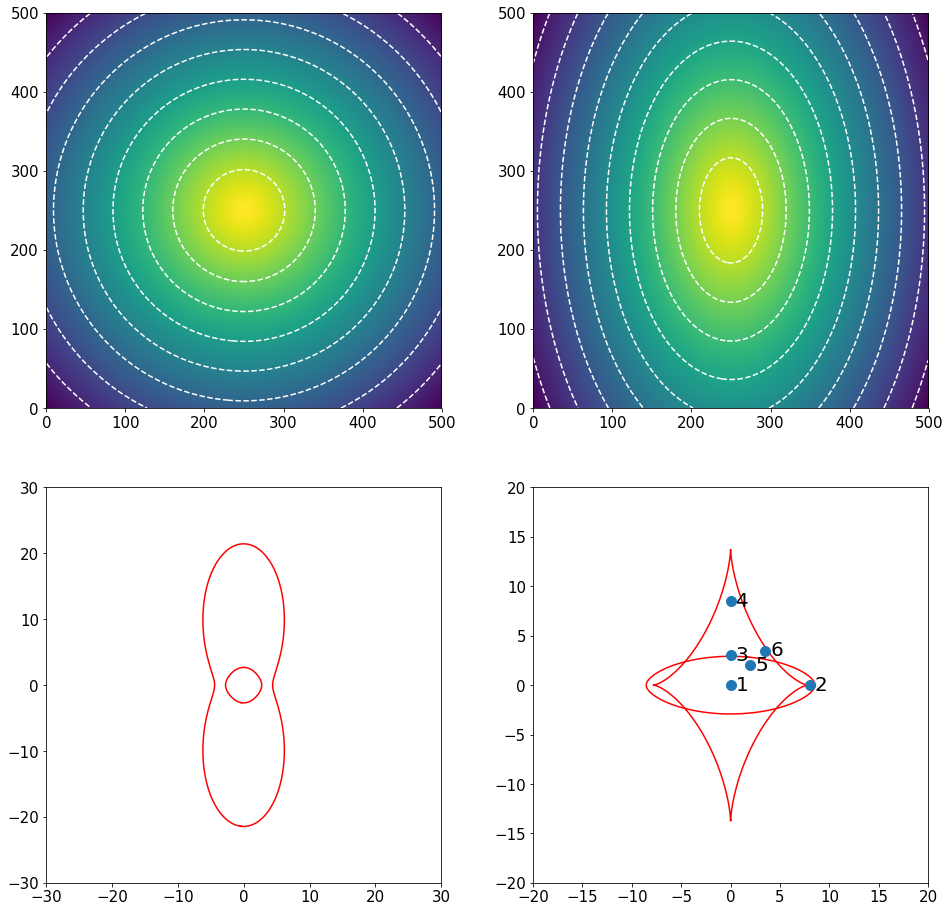

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.ndimage import map_coordinates
import pylab



class psie(object):
    def __init__(self,theta_c=0.0,ell=0.0,norm=1.0):
        self.theta_c=theta_c
        self.ell=ell
        self.norm=norm
        self.pot_exists=False
        
    def t_grav_surf(self,size=40.0,npix=500.0):
        pixel=size/(npix-1)
        x = np.arange(0, npix, 1, float)
        y = x[:,np.newaxis]
        x0 = y0 = npix / 2
        self.size=size
        self.npix=npix
        no=(self.size/(self.npix-1))**2
        self.pot_exists=True
        pot=np.sqrt(((x-x0)*pixel)**2/(1-self.ell)
                         +((y-y0)*pixel)**2*(1-self.ell)
                         +self.theta_c**2)*self.norm
        self.pot=pot/(self.size/self.npix)**2
        self.a2,self.a1=np.gradient(self.pot)
        self.a12,self.a11=np.gradient(self.a1)
        self.a22,self.a21=np.gradient(self.a2)
        return -pot
    
    def t_geom_surf(self,size=40.0, npix=500.0, beta=None):
        pixel=size/(npix-1) 
        x = np.arange(0, npix, 1, float)*pixel
        y = x[:,np.newaxis]
        if beta is None:
            x0 = y0 = npix / 2*pixel
        else:
            x0 = beta[0]+npix/2*pixel
            y0 = beta[1]+npix/2*pixel
        
        return 0.5*((x-x0)*(x-x0)+(y-y0)*(y-y0))
    
    def t_delay_surf(self,size=40.0,npix=500,beta=None):
        t_grav=self.t_grav_surf(size,npix)
        t_geom=self.t_geom_surf(size,npix,beta)
        return(t_grav+t_geom)
    
    def convergence(self):
        if (self.pot_exists):
            kappa=0.5*(self.a11+self.a22)
        else:
            print ("The lens potential is not initialized yet")
            
        return(kappa)
    
    def shear(self):
        if (self.pot_exists):
            g1=0.5*(self.a11-self.a22)
            g2=self.a12
        else:
            print ("The lens potential is not initialized yet")
        return(g1,g2)
    
    def detA(self):
        if (self.pot_exists):
            deta=(1.0-self.a11)*(1.0-self.a22)-self.a12*self.a21
        else:
            print ("The lens potential is not initialized yet")
        return(deta)
            
    def crit_lines(self,ax=None,show=True):
        if (ax==None): 
            print ("specify the axes to display the critical lines")
        else:
            deta=self.detA()
            ax.imshow(deta,origin='lower')
            cs=ax.contour(deta,levels=[0.0],colors='white')
            if show==False:
                ax.clear()
        return(cs)
    
    def clines(self,ax=None):
        cs=self.crit_lines(ax=ax,show=False)
        contour=cs.collections[0]
        p=contour.get_paths()
        sizevs=np.empty(len(p),dtype=int)
        
        no=self.size/(self.npix-1)
        # if we found any contour, then we proceed
        if (sizevs.size > 0):
            for j in range(len(p)):
                # for each path, we create two vectors containing 
                #the x1 and x2 coordinates of the vertices
                vs = contour.get_paths()[j].vertices 
                sizevs[j]=len(vs)
                x1=[]
                x2=[]
                for i in range(len(vs)):
                    xx1,xx2=vs[i]
                    x1.append(float(xx1))
                    x2.append(float(xx2))
        
                # plot the results!
                ax.plot((np.array(x1)-self.npix/2.)*no,
                        (np.array(x2)-npix/2.)*no,'-',color='red')
        
    def caustics(self,ax=None):
        cs=self.crit_lines(ax=ax,show=False)
        contour=cs.collections[0]
        p=contour.get_paths() # p contains the paths of each individual 
                              # critical line

        sizevs=np.empty(len(p),dtype=int)
        
        # if we found any contour, then we proceed
        if (sizevs.size > 0):
            for j in range(len(p)):
                # for each path, we create two vectors containing 
                # the x1 and x2 coordinates of the vertices
                vs = contour.get_paths()[j].vertices 
                sizevs[j]=len(vs)
                x1=[]
                x2=[]
                for i in range(len(vs)):
                    xx1,xx2=vs[i]
                    x1.append(float(xx1))
                    x2.append(float(xx2))
                # these are the points we want to map back on the source plane. 
                # To do that we need to evaluate the deflection angle at their positions
                # using scipy.ndimage.interpolate.map_coordinates we perform a bi-linear interpolation
                a_1=map_coordinates(self.a1, [[x2],[x1]],order=1)
                a_2=map_coordinates(self.a2, [[x2],[x1]],order=1)
        
                # now we can make the mapping using the lens equation:
                no=self.size/(self.npix-1)
                y1=(x1-a_1[0]-self.npix/2.)*no
                y2=(x2-a_2[0]-self.npix/2.)*no
        
                # plot the results!
                #ax.plot((np.array(x1)-npix/2.)*no*f,(np.array(x2)-npix/2.)*no*f,'-')
                ax.plot(y1,y2,'-',color='red')

    def show_surface(self,surf,ax=None,minx=-25,miny=-25,vmax=2,rstride=1,
                     cstride=1,cmap=plt.get_cmap('Paired'),
                     linewidth=0, antialiased=False,alpha=0.2,fontsize=20):
        if ax==None:
            print ("specify the axes with 3d projection to display the surface")
        else:
            xa=np.arange(-self.npix/2, self.npix/2, 1)
            ya=np.arange(-self.npix/2, self.npix/2, 1)
        # I will show the contours levels projected in the x-y plane
            levels=np.linspace(np.amin(surf),np.amax(surf),40)

            minx=minx
            maxx=-minx

            miny=-25
            maxy=-miny

            pixel_size=self.size/(self.npix-1)
            X, Y = np.meshgrid(xa*pixel_size, ya*pixel_size)
            ax.plot_surface(X,Y,surf,vmax=vmax,rstride=rstride, cstride=cstride, cmap=cmap,
                       linewidth=linewidth, antialiased=antialiased,alpha=alpha)

            cset = ax.contour(X, Y, surf, zdir='z', 
                               offset=np.amin(surf)-20.0, cmap=cmap,levels=levels)
            deta=self.detA()
            cset = ax.contour(X, Y, deta, zdir='z', 
                               offset=np.amin(surf)-20.0, colors='black',levels=[0])            
            cset = ax.contour(X, Y, surf, zdir='x', offset=minx, cmap=cmap,levels=[0])
            cset = ax.contour(X, Y, surf, zdir='y', offset=maxy, cmap=cmap,levels=[0])
            ax.set_xlim3d(minx, maxx)
            ax.set_ylim3d(miny, maxy)
            ax.set_zlim3d(np.amin(surf)-20.0, 10)
            ax.set_xlabel(r'$\theta_1$',fontsize=fontsize)
            ax.set_ylabel(r'$\theta_2$',fontsize=fontsize)
            ax.set_aspect('equal')    
            
    def show_contours(self,surf,ax=None,minx=-25,miny=-25,vmax=2,rstride=1,
                     cstride=1,cmap=plt.get_cmap('Paired'),
                     linewidth=0,fontsize=20):
        if ax==None:
            print ("specify the axes with 3d projection to display the surface")
        else:
            surf=surf+np.min(surf)
            levels=np.linspace(np.amin(surf),np.amax(surf),40)
            ax.contour(surf, cmap=cmap,levels=levels)
            ax.set_xlim(minx, maxx)
            ax.set_ylim(miny, maxy)
            ax.set_xlabel(r'$\theta_1$',fontsize=fontsize)
            ax.set_ylabel(r'$\theta_2$',fontsize=fontsize)
            ax.set_aspect('equal')    

            
%matplotlib inline

size=60.
npix=500.
cl=psie(theta_c=2.0,norm=10.0)
el=psie(ell=0.4,theta_c=2.0,norm=10)

t_grav_surf0=cl.t_grav_surf(size,npix)
t_grav_surf=el.t_grav_surf(size,npix)

l0=np.linspace(t_grav_surf0.min(),t_grav_surf0.max(),10)

fig,ax=plt.subplots(2,2,figsize=(16,16))
ax[0,0].imshow(t_grav_surf0,origin='lower')
ax[0,1].imshow(t_grav_surf,origin='lower')
ax[0,0].contour(t_grav_surf0,levels=l0,colors='white')
ax[0,1].contour(t_grav_surf,levels=l0,colors='white')
el.clines(ax=ax[1,0])
el.caustics(ax=ax[1,1])
ax[1,0].set_xlim([-30,30])
ax[1,0].set_ylim([-30,30])
ax[1,1].set_xlim([-20,20])
ax[1,1].set_ylim([-20,20])

betax=[0,8,0,0,2,3.5]
betay=[0,0,3,8.5,2,3.5]
labels=['1','2','3','4','5','6']
ax[1,1].plot(betax,betay,'o',markersize=10)
for i, txt in enumerate(labels):
    ax[1,1].annotate(txt, (betax[i]+0.5,betay[i]-0.5),fontsize=20)

fig.savefig('ellipt_lens.png')

The figure above shows (from the upper left to the bottom right):

* the map of an axially simmetric potential (circular)
* the map obtained by introducing the ellipticity in the potential
* the critical lines of the lens
* the caustics and some positions of the source with respect to the lens.

Note that pseudo-elliptical lenses do not have elliptical mass distributions. The map below is the lens convergence. The white lines show some levels of constant convergence.

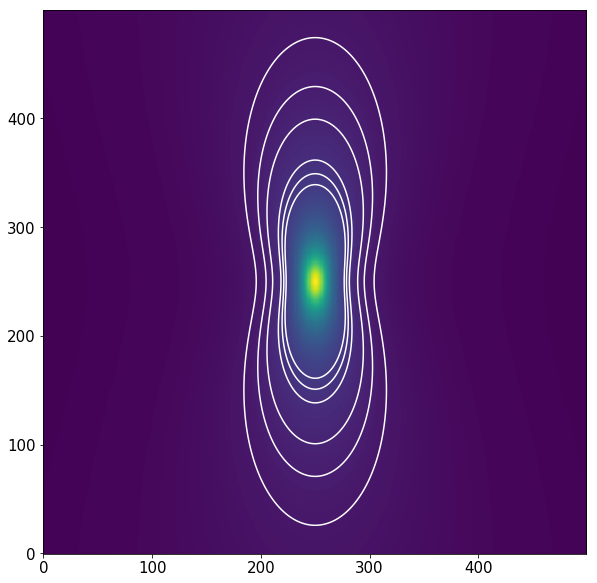

In [98]:
kappa=el.convergence()
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(kappa,origin='lower')
ax.contour(kappa,levels=[0.4,0.5,0.6,0,7,0.8,0.9,1.0],colors='white')

Note that the lens has its major axis oriented along the $\theta_2$ axis. Now we can proceed with the computation of the time delay surface and its 3D representation. The shape of the surface depends on the source position. We  show two figures. On the left, we show the caustics of the lens and the position of the source relative to the caustics. On the right, the corresponding time delay surface.

<IPython.core.display.Javascript object>


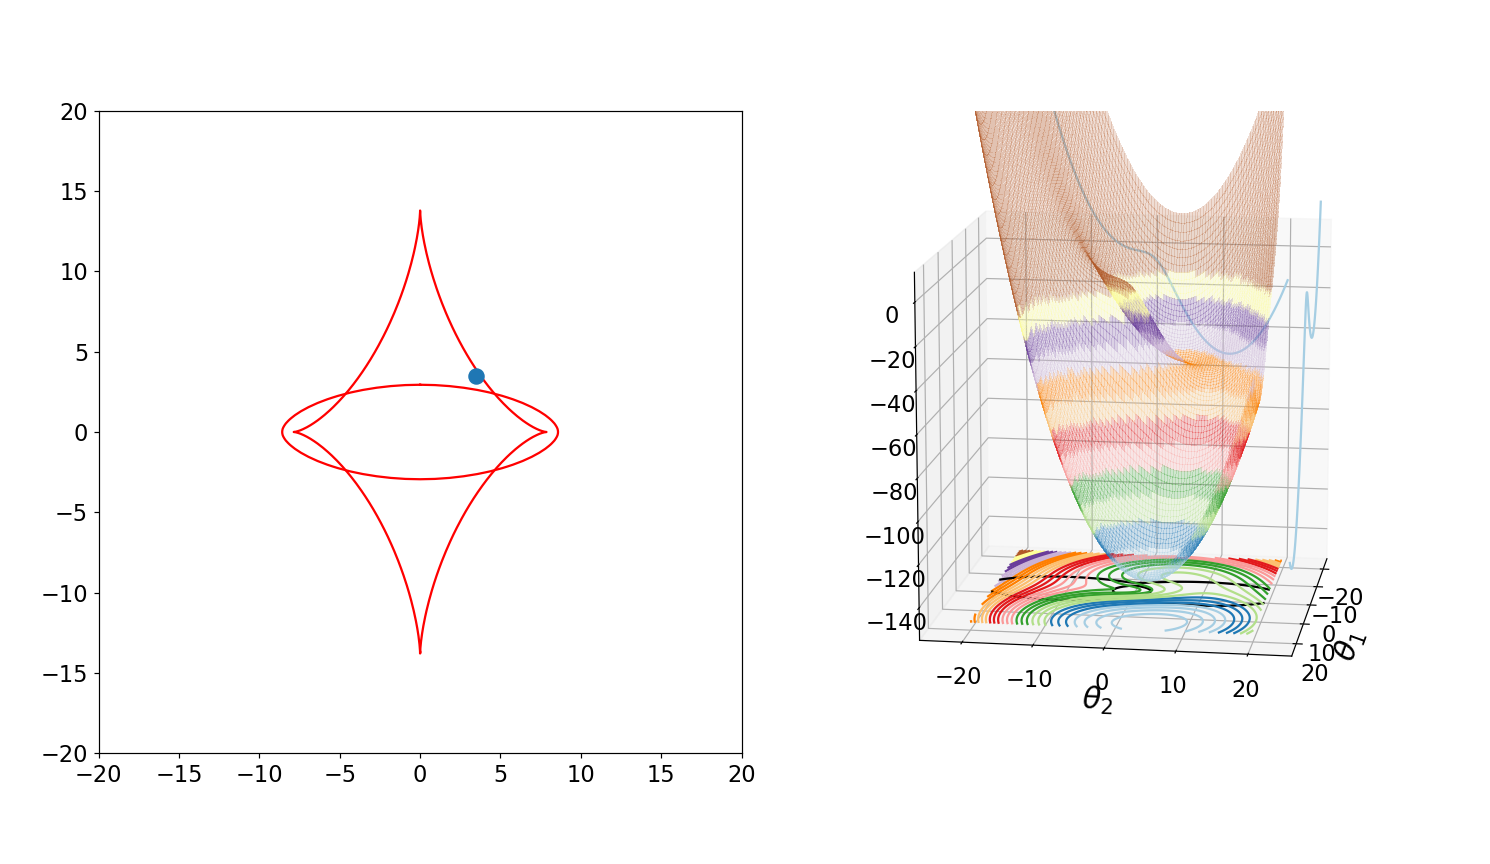

In [109]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 25}
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rc('font', **font)

label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size
%matplotlib notebook
#plt.ion()
#%matplotlib notebook

# source params
beta1=betax[5]#0.
beta2=betay[5]#0.
beta=[beta1,beta2]

# lens params
ell=0.4
theta_c=2.0

fig = plt.figure(figsize=(13.8,8))
ax=fig.add_subplot(121)
el=psie(ell=ell,theta_c=theta_c,norm=10)
el.t_grav_surf(size*1.2,250)
el.caustics(ax=ax)
ax.plot(beta[0],beta[1],'o',markersize=10)
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
ax.set_aspect('equal')


ax3d = fig.add_subplot(122, projection='3d')

npix=100
size=40.0
el3d=psie(ell=ell,theta_c=theta_c,norm=10)
td3d=el3d.t_delay_surf(npix=npix,size=size,beta=beta)
el3d.show_surface(td3d,ax=ax3d)
fig.tight_layout()